# Kwalitatieve analyse

We gaan met behulp van Python en bijbehorende frameworks een kwalitatieve data analyse uitvoeren op de afgenomen diepteinterviews. Deze zijn getranscribeerd en omzet in YAML, een programmeertaal voor gegevensserialisatie. Dit bestand bestaat uit de interviewvragen en het bijbehorende antwoord. Eerst uploaden we de transcripties met alle interviews.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving transcripties.yaml to transcripties.yaml


Vervolgens gebruiken we het Pandas framework om de YAML databestanden in een tabel te zetten: een zogeheten DataFrame. Dit DataFrame zal bestaan uit een kolom 'vraag' en 'antwoord'. We laten even als voorbeeld de eerste vijf rijen van het DataFrame zien.

In [ ]:
import pandas as pd
import yaml

FILE_PATH = "transcripties.yaml"

# Functie die een YAML bestand in een DataFrame zet
def create_dataframe(file_path):
  rows = []

  # Lees het YAML bestand in
  with open(file_path) as file:
    data = yaml.safe_load(file)

    # Voeg elke vraag en bijbehorend antwoord toe als rij in de tabel
    for item in data:
      values = list(item.values())[0]
      rows.append([values["vraag"], values["antwoord"]])

  # Creeer het DataFrame met kolommen 'vraag' en 'antwoord'
  df = pd.DataFrame(rows, columns=["vraag", "antwoord"])
  return df

interviews = create_dataframe(FILE_PATH)
interviews.head()

,vraag,antwoord
0,Wij willen graag weten waar u zich nou aan erg...,"Oh, dan moet ik even denken hoor... Nou, ik vi..."
1,Heeft u een voorbeeld van iets?,Ik kan zelfs een concreet voorbeeld geven. Een...
2,Is uw belasting erg gestegen dan?,"Dat merk ik zeker wel. Kijk, ik woon al jaren ..."
3,Waar had u liever gezien dat het geld naar toe...,Er zijn wel een aantal wegen hier achter die v...
4,Het is toch de bedoeling dat het verplaatst wo...,"Ja, die hele boel moet nu verplaatst worden na..."


## Data ordening

Met behulp het NLTK framework (een taalverwerkingsalgoritme in Python) gaan we de interviews *tokeniseren*. Hierbij wordt een tekst opgedeeld in kleinere eenheden, genaamd tokens. Dit kunnen woorden, zinnen, uitdrukkingen of andere elementen zijn. We downloaden ook een lijst met stopwoorden om deze buiten beschouwing te laten.

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Download de Nederlandse stopwoordenlijst en de tokenizer
nltk.download("stopwords")
nltk.download("punkt")
stop_words = set(stopwords.words("dutch"))
tokenizer = RegexpTokenizer("\w+")

# Functie voor de tokenisatie
def preprocess_text(text):
  tokens = tokenizer.tokenize(text.lower())
  filtered_tokens = [token for token in tokens if token not in stop_words]
  return filtered_tokens

# Woordtokensitie van de vragen en antwoorden
interviews["vraag_woorden"] = interviews["vraag"].apply(preprocess_text)
interviews["antwoord_woorden"]= interviews["antwoord"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vervolgens kan NLTK de frequentie tellen van de woorden die voorkomen in de antwoorden. Helaas is NLTK vooral getraind op Engels, waardoor we functionaliteiten zoals het bepalen van woordsoorten of stamvormen niet kunnen gebruiken. We laten als voorbeeld de eerste 25 woorden van de frequentielijst zien.

In [ ]:
import numpy as np

# Voeg alle woorden bij elkaar toe als de variabele 'words'
words = np.concatenate(interviews["antwoord_woorden"].values)

# Bereken de frequentie van elk woord
frequency = nltk.FreqDist(words)

# Sorteer de woorden op basis van de hoogste frequentie
sorted_frequency = sorted(frequency.items(), key=lambda x: x[1], reverse=True)

for word, freq in sorted_frequency[:25]:
    print(f"{freq}: {word}")

85: wel
52: vind
46: heel
41: nou
38: nijkerk
37: we
31: echt
29: gemeente
26: goed
26: mensen
26: gewoon
24: weet
22: gaat
22: geld
21: allemaal
20: gemeentehuis
20: denk
17: waar
17: dingen
17: nee
16: gaan
16: bijvoorbeeld
15: moeten
14: helemaal
14: jaar


## Datareductie

Aan de hand van de volledige woordenlijst krijgen we een beter beeld over bij welke onderwerpen de geinterviewden betrokken zijn. We zullen de woorden die vaak voorkomen en **relevant** zijn voor ons onderzoek gebruiken om verder te gaan. Zie de onderstaande grafiek hiervoor.


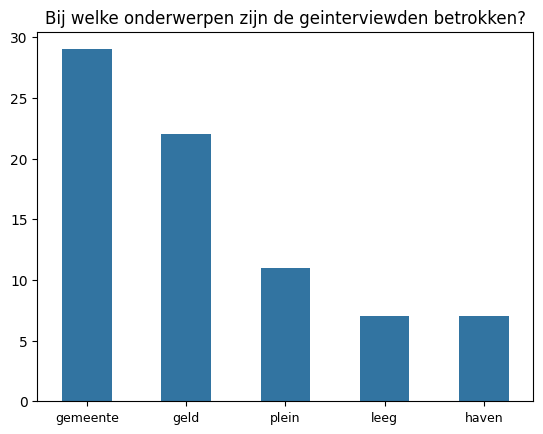

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecteer de relevante onderwerpen uit de woordenlijst
sorted_frequency = pd.DataFrame(sorted_frequency, columns=["woord", "frequentie"])
relevant_subjects = sorted_frequency[sorted_frequency["woord"].isin(["leeg", "plein", "haven", "gemeente", "geld"])]

# Creeer een staafdiagram
sns.barplot(x="woord", y="frequentie", data=relevant_subjects, width=0.5)

plt.title("Bij welke onderwerpen zijn de geinterviewden betrokken?")
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=9)

plt.show()

De volgende stap is het ordenen van de data op basis van hun onderwerp. We gaan fragmenten die over hetzelfde onderwerp gaan van een nummer voorzien. Aan de hand van de woordenlijst zoeken we ook fragmenten die te maken hebben met het tweede deel van de centrale vraag, de nieuwsbehoeften van de bewoners.

Onze genummerde onderwerpen zijn dus:
1. Nieuws
2. Krant
3. Mening
4. Praten
5. Leeg(stand)
6. Plein
7. Haven
8. Gemeente(huis)
9. Geld

In [ ]:
# Definieer de onderwerpen waar we naar gaan zoeken
subjects = {"nieuws": 1, "krant": 2, "mening": 3, "praten": 4, "leeg": 5, "plein": 6, "haven": 7, "gemeente": 8, "geld": 9}
pattern = "|".join(subjects.keys())

# Filter de interviewvragen en antwoorden op basis van de onderwerpen
mask = interviews["vraag"].str.contains(pattern, case=False) | interviews["antwoord"].str.contains(pattern, case=False)
filtered_interviews = interviews[mask]

# Voeg de bijbehorende onderwerpen toe als nummer in de tabel
filtered_interviews["nummer"] = filtered_interviews.apply(lambda row: next((subjects[subject] for subject in subjects if subject in row["vraag"] or subject in row["antwoord"]), None), axis=1)
filtered_interviews = filtered_interviews.dropna(subset=['nummer'])
filtered_interviews["nummer"] = filtered_interviews["nummer"].astype(int).astype(str)

<ipython-input-357-aa57f5f2394c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interviews["nummer"] = filtered_interviews.apply(lambda row: next((subjects[subject] for subject in subjects if subject in row["vraag"] or subject in row["antwoord"]), None), axis=1)


Nu dat het DataFrame alleen nog fragmenten bevat die relevant zijn voor ons onderzoek kunnen we verder kijken welke delen van deze fragmenten betekenisvol zijn. We tokeniseren hiervoor eerst alle fragmenten naar zinnen. We filteren minder belangrijke zinnen van onder de 10 woorden voor nu uit de dataset.

In [ ]:
# Zintokenisatie
filtered_interviews["vraag_zinnen"] = filtered_interviews["vraag"].apply(nltk.sent_tokenize)
filtered_interviews["antwoord_zinnen"] = filtered_interviews["antwoord"].apply(nltk.sent_tokenize)

summary_sentences = []

# Filter de zinnen op basis van lengte
for answer in filtered_interviews["antwoord_zinnen"]:
  for sentence in answer:
    if len(sentence.split(" ")) > 10:
      summary_sentences.append(sentence)

# Haal de korte zinnen uit het DataFrame
def filter_fragments(row):
  fragment = row["antwoord"]
  for sentence in summary_sentences:
    if sentence in fragment:
      return sentence
  return None

interview_fragments = filtered_interviews[filtered_interviews["antwoord"].apply(lambda x: any(sentence in x for sentence in summary_sentences))]
interview_fragments["antwoord"] = interview_fragments.apply(filter_fragments, axis=1)

<ipython-input-358-4dac613fcb46>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interview_fragments["antwoord"] = interview_fragments.apply(filter_fragments, axis=1)


Daarna tellen we hoevaak een zin per onderwerp voorkomt, om dit bij te houden in de tabel. De onderstaande tabel is het resultaat van de datareductie.

In [ ]:
# Tel hoe vaak elk onderwerp voorkomt
subject_counts = {}

def update_subject(subject):
  if subject in subject_counts:
    subject_counts[subject] += 1
  else:
    subject_counts[subject] = 1
  return f"{subject}.{subject_counts[subject]}"

# Update de nummers van de tabel op basis van hoe vaak het onderwerp voorkomt
interview_fragments["nummer"] = interview_fragments["nummer"].apply(update_subject)
interview_fragments[["nummer", "antwoord"]].head()

<ipython-input-359-3bfe50971484>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interview_fragments["nummer"] = interview_fragments["nummer"].apply(update_subject)


,nummer,antwoord
0,8.1,"Oh, dan moet ik even denken hoor... Nou, ik vi..."
1,6.1,Een paar maanden geleden hebben ze hier bij Pl...
3,5.1,Er zijn wel een aantal wegen hier achter die v...
4,3.1,"Ja, die hele boel moet nu verplaatst worden na..."
5,5.2,"Ik zal je eens iets vertellen, weet jij waarom..."


Vanwege de limitaties van NLTK zullen we handmatig de overblijvende fragmenten van labels moeten voorzien. Ook kan het zijn dat er nog wat niet-relevante antwoorden in de tabel zitten of dat het verkeerd genummerd is. We zetten het DataFrame om naar een Excel bestand.

In [ ]:
interview_fragments[["nummer", "antwoord"]].to_excel("coderingsschema.xlsx", index=False)